# Utilities

In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [305]:
class DynamicalProcess(): # TODO rename to TranslocationModel
    """A dynamical process defined by a kinetic scheme.
    
    The kinetic scheme is a directed graph where the nodes are the states of
    the system and the edges are the reactions. The nodes have a 'probability'
    attribute, which is the probability of the steady-state system to be in
    this state. The directed edges have a 'rate' attribute, which is the rate
    of the reaction. 

    The dynamical process is a stochastic process. It can be simulated using
    the Gillespie algorithm. The stochastic process is a single particle
    evoluting on the kinetic scheme. 

    We a re interested in the position of the particle over time, for various
    models such as 'Sequential Clockwise/2-Residue Step' or 'Disc-Spiral'.
    """

    def __init__(self, 
                 kinetic_scheme: nx.DiGraph, 
                 transition_up: tuple[str, str],# TODO add possibility to have more than one transition_up
                 n_residues_per_step: int, 
                 n_protomers: int = 6):
        """Initialize the dynamical process.

        Args:
            kinetic_scheme: The kinetic scheme of the dynamical process.
                The nodes are the states of the system. Nodes must have a 
                'probability' attribute, which is the probability of the
                steady-state system to be in this state.
                The directed edges are the reactions, from the reactant to the 
                product. Edges must have a 'rate' attribute.
            transition_up: The transition that increases the position by 1. 
                Example: ("DTT", "TTD"). It is assumed that for each
                transition_up, there exists a inverse transition_down, with the 
                above example it would be: ("TTD", "DTT").
            n_residues_per_step: The number of residues per step.
            n_protomers: The number of protomers in the protein.
        """

        if transition_up not in kinetic_scheme.edges():
            raise ValueError("The transition_up does not belong to the graph.")

        self.kinetic_scheme = kinetic_scheme
        self.transition_up = transition_up
        self.n_residues_per_step = n_residues_per_step
        self.n_protomers = n_protomers # TODO verify that it is used somewhere

    def gillespie(self, maxiter: int = 1000, initial_state: None | str = None,
                  positions: bool = False) -> pd.DataFrame:
        """Simulate the stochastic system using the Gillespie algorithm.

        Simulate the stochastic evolution of a single particle evoluting on 
        the kinetic scheme using the Gillespie algorithm.

        Args:
            maxiter: The maximum number of simulation iterations.
            initial_state: The initial state of the system.
            positions: If False, return the state and sojourn time at each step.
                If True, return the position and timestamp at every changement 
                of the position. 
            

        Returns:
            A dataframe containing the sojourn times spent in each state, or 
            the positions and timestamps of the stochastic process, depending
            on the positions argument.
        """

        if maxiter < 1:
            raise ValueError(
                "The maximum number of iterations must be strictly greater than 0.")
        if initial_state and initial_state not in self.kinetic_scheme.nodes():
            raise ValueError("The initial state does not belong to the graph.")
        
        if not initial_state:
            initial_state = list(self.kinetic_scheme.nodes())[0]

        # State of the system all along the simulation and the sojourn time
        # spent in each state
        states = [initial_state]
        sojourn_times = []

        while True:
            current_state = states[-1]
            # Rate of each reaction leaving the current state keyed by the 
            # product (i.e. next state) of the reaction
            rates = {
                terminal_node: rate 
                    for _, terminal_node, rate in 
                    self.kinetic_scheme.out_edges(current_state, data='rate')}
            
            # Total rate of leaving the current state is the sum of all the 
            # leaving rates
            rate_tot = sum(rates.values()) 
            # Time spent in the current state (sojourn time) is an exponential 
            # random variable with parameter 1/rate_tot
            sojourn_times.append(np.random.exponential(1/rate_tot))

            if len(sojourn_times) >= maxiter:
                break

            # Choose the next state
            states.append(
                np.random.choice(list(rates.keys()), 
                                 p=[rate/rate_tot for rate in rates.values()]))
            
        # Store sojourn time spent in each state in a dataframe
        states_and_sojourn_times = pd.DataFrame(
            {'state': states, 'sojourn_time': sojourn_times})
        states_and_sojourn_times['state'] = (states_and_sojourn_times['state']
                                             .astype('category'))
        
        if positions:
            out = self._compute_positions(states_and_sojourn_times)
        else:
            out = states_and_sojourn_times

        return out
    
    def plot_position_evolution(self, 
                                positions: pd.DataFrame, 
                                time_unit: str, 
                                position_unit: str = "#Residues", 
                                kinetic_scheme_image_path: str | None = None, 
                                ax: mpl.axes.Axes | None = None,
                                title: str | None = None,
                                ) -> (mpl.axes.Axes 
                                      | tuple[mpl.figure.Figure, mpl.axes.Axes]):
        """Plot the evolution of the position.

        Args:
            positions: Position and timestamp at every changement of the 
                position (in residues, not steps). It must have these two
                columns: 'timestamp' and 'position'.
            time_unit: Unit of the time (x-)axis
            position_unit: Unit of the position (y-)axis
            kinetic_scheme_image_path: If given, will add the image of the
                kinetic scheme on the plot.
            ax: The axes where to plot. If None, a new figure and axes is 
                created and returned.
            title: The title of the plot. If None, no title is added.

        Returns:
            The axes with the plot if axis is non None, or both the newly
            created figure and axes.
        """

        ax_given = True # Flag indicating if ax is given by user or not
        if not ax:
            fig, ax = plt.subplots(figsize=(6, 6))
            ax_given = False
        
        ax.step(positions["timestamp"], positions["position"], where="post", 
                label="From Gillespie algorithm")
        ax.plot(positions["timestamp"], 
                positions["timestamp"] * self.average_velocity(), 
                label="From average velocity")
        ax.set_xlabel("Time" + " [" + time_unit + "]")
        ax.set_ylabel("Position" + " [" + position_unit + "]")
        ax.legend()
        if kinetic_scheme_image_path:
            img = np.asarray(Image.open(kinetic_scheme_image_path))
            sub_ax = ax.inset_axes([0.55, 0., 0.44, 0.44])
            sub_ax.imshow(img)
            sub_ax.axis('off')

        if title:
            ax.set_title(title)

        if ax_given:
            return ax
        else:
            return fig, ax
    
    def _compute_positions(self, states_and_sojourn_times: pd.DataFrame
                           ) -> pd.DataFrame:
        """Compute the position and timestamp at every changement of the position.

        Given the states and sojourn times of the stochastic process from the
        Gillespie algorithm, compute the position (in residues, not steps)
        every time the position changes and the corresponding timestamp. 
        The step size is given by the n_residues_per_step attribute.
        """

        # Dataframe containing the transition StateA -> StateB as tuples 
        # (StateA, StateB) and the timestamp of the transition
        transitions = states_and_sojourn_times.copy()
        transitions.rename(columns={"state": "state_from"}, inplace=True)
        transitions["state_to"] = transitions["state_from"].shift(-1)
        transitions["state_from_to"] = list(zip(transitions["state_from"], 
                                                transitions["state_to"]))
        transitions["timestamp"] = transitions["sojourn_time"].cumsum()
        # Keep only data about the transitions, i.e. keep only the transitions 
        # per se, its timestamp and remove the last row as it is not a transition.
        transitions.drop(columns=["sojourn_time", "state_from", "state_to"], 
                         inplace=True)
        transitions.drop(transitions.tail(1).index, inplace=True)

        # Dataframe with the timestamp and position everytime the position changes
        positions = transitions.copy()
        # The position is the sum of the number of steps up minus the number of 
        # steps down, multiplied by the number of residues per step
        positions["position"] = (
            ((transitions["state_from_to"] == self.transition_up).cumsum() 
             - (transitions["state_from_to"] == self.transition_up[::-1]).cumsum())
            * self.n_residues_per_step)
        positions.drop(columns=["state_from_to"], inplace=True)
        # Add a row at the top with the initial position at timestamp 0
        positions = pd.concat([pd.DataFrame({"timestamp": [0], "position": [0]}), 
                               positions]).reset_index(drop=True)
        # Keep only the rows where the position changes and the row at the top
        mask = (positions["position"]
                .rolling(2).apply(lambda x: x.iat[0] != x.iat[1]).astype(bool))
        positions = positions[mask]

        return positions
    
    def average_velocity(self) -> float:
        """Return the average velocity of the dynamical process.

        The average velocity is computed analytically from the kinetic scheme
        using formula: 
            v = (p_lower * rate_up - p_upper * rate_down) * residues_per_step
        The unit depends on the unit of the rates.
        """

        v = (
            self.kinetic_scheme.nodes[self.transition_up[0]]['probability'] # p_lower
            * self.kinetic_scheme.edges[self.transition_up]['rate'] # rate_up
            - self.kinetic_scheme.nodes[self.transition_up[1]]['probability'] # p_upper
            * self.kinetic_scheme.edges[self.transition_up[::-1]]['rate'] # rate_down
        ) * self.n_residues_per_step
        return v
    
    def ATP_consumption_rate(self, ):# list of edges that consume ATP TODO
        pass
    
    def normalize_average_velocity(self, inplace: bool = False):
        """Normalize the average velocity of the dynamical process.

        Can be used to compare different models.
        When the velocity is normalized, the units # TODO
        """

        if self.average_velocity() == 0:
            raise ValueError("The average velocity is null, cannot normalize.")
        
        average_velocity = self.average_velocity() # Velocity before normalization
        kinetic_scheme = (self.kinetic_scheme if inplace 
                          else self.kinetic_scheme.copy())
        for edge in kinetic_scheme.edges():
            kinetic_scheme.edges[edge]['rate'] /= average_velocity
        return kinetic_scheme
        

# Simulations

In [57]:
savefig = False # Indicate if we want to save the figures

In [123]:
# TODO think about what we want to define, think about the units
# Only ratios is enough?
# Rates that are similar in all models

# Association/dissociation protomer-ATP/ADP rates
k_on_ATP = 1
k_off_ATP = 1
k_on_ADP = 1
k_off_ADP = 1

# ATP/ADP hydrolysis/synthesis rates
k_h = 1
k_s = 1

# Protomer-ATP/ADP dissociation constants
K_d_ATP = k_off_ATP / k_on_ATP
K_d_ADP = k_off_ADP / k_on_ADP


## Spiraling in Control: Sequential Clockwise/2-Residue Step



### 1 loop

![](SC_2RS_kinetic_scheme.jpg)

In [307]:
# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_down = k_h * k_up * k_DT / (k_s * k_TD) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Analytical probability of being in each state
p_TTT = k_s * k_DT + k_s * k_down + k_up * k_DT
p_DTT = k_h * k_down + k_down * k_TD + k_h * k_DT
p_TTD = k_up * k_TD + k_s * k_TD + k_h * k_up
normalization_factor = p_TTT + p_DTT + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_TTD /= normalization_factor

kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("TTT", {'probability': p_TTT}),
    ("DTT", {'probability': p_DTT}),
    ("TTD", {'probability': p_TTD}),
])
kinetic_scheme.add_edges_from([
    ("TTT", "DTT", {'rate': k_h}), 
    ("DTT", "TTT", {'rate': k_s}),
    ("DTT", "TTD", {'rate': k_up}), 
    ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT}), 
    ("TTT", "TTD", {'rate': k_TD})]
)

SC_2R_1_loop = DynamicalProcess(kinetic_scheme, ("DTT", "TTD"), 2)

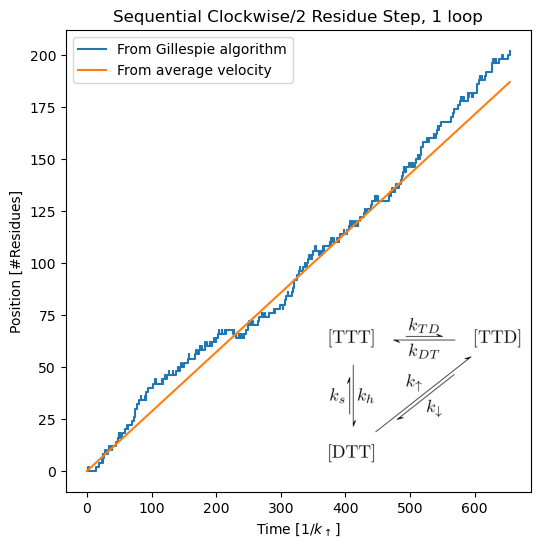

In [342]:
positions = SC_2R_1_loop.gillespie(positions=True)
fig, ax = SC_2R_1_loop.plot_position_evolution(
    positions, 
    r"$1/k_\uparrow$", 
    kinetic_scheme_image_path="SC_2R_1_loop_kinetic_scheme.jpg",
    title="Sequential Clockwise/2 Residue Step, 1 loop")
plt.show()

### 2 different loops

![](SC_2RS_4_states_kinetic_scheme.jpg)

In [326]:
# Protomer-ATP/ADP dissociation constants
# Main loop (1)
K_d_ATP_1 = 1
K_d_ADP_1 = 1
# Second loop (2)
K_d_ATP_2 = 1
K_d_ADP_2 = 1

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Transition rates

# Effective ATP/ADP exchange rates
# Main loop
k_DT_1 = 1
# Constraint from ATP-ADP exchange model
k_TD_1 = k_DT_1 * K_d_ATP_1 / K_d_ADP_1 / ATP_over_ADP
# Second loop
k_DT_2 = 0.1
# Constraint from ATP-ADP exchange model
k_TD_2 = k_DT_2 * K_d_ATP_2 / K_d_ADP_2 / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
k_down = 0.1

# ATP/ADP hydrolysis/synthesis rates
# Main loop
k_h_1 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_1 = k_h_1 * k_up * k_DT_1 / (k_down * k_TD_1) * ATP_over_ADP_equilibrium / ATP_over_ADP
# Second loop
k_h_2 = 0.1
# Thermodynamic constraint from kinetic scheme
k_s_2 = k_h_2 * k_up * k_DT_2 / (k_down * k_TD_2) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Probability weights
p_TTT = (k_s_1 * k_DT_1 * (k_DT_2 + k_s_2)
         + k_s_1 * (k_DT_2 * k_down + k_s_2 * k_down + k_DT_2 * k_h_2)
         + k_DT_1 * (k_up * k_s_2 + k_up * k_DT_2 + k_DT_2 * k_s_2))
p_DTT = (k_DT_2 * k_down * k_h_1
         + k_DT_2 * k_down * k_TD_1
         + k_down * k_h_1 * k_s_2
         + k_DT_2 * k_h_1 * (k_h_2 + k_DT_1)
         + k_DT_2 * k_h_2 * k_TD_1
         + k_down * k_s_2 * k_TD_1
         + k_h_1 * k_s_2 * k_DT_1)
p_DTD = (k_h_2 * k_TD_2 * (k_TD_1 + k_h_1)
         + k_h_2 * (k_TD_1 * k_up + k_h_1 * k_up + k_TD_1 * k_s_1)
         + k_TD_2 * (k_down * k_h_1 + k_down * k_TD_1 + k_DT_1 * k_h_1))
p_TTD = (k_TD_1 * k_up * k_s_2
         + k_TD_1 * k_up * k_DT_2
         + k_up * k_s_2 * k_h_1
         + k_TD_1 * k_s_2 * (k_s_1 + k_TD_2)
         + k_TD_1 * k_s_1 * k_DT_2
         + k_up * k_h_1 * k_DT_2
         + k_s_2 * k_h_1 * k_TD_2)
normalization_factor = p_TTT + p_DTT + p_DTD + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_DTD /= normalization_factor
p_TTD /= normalization_factor

# Model
kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("TTT", {'probability': p_TTT}),
    ("DTT", {'probability': p_DTT}),
    ("DTD", {'probability': p_DTD}),
    ("TTD", {'probability': p_TTD}),
])
kinetic_scheme.add_edges_from([
    ("TTT", "DTT", {'rate': k_h_1}), ("DTT", "TTT", {'rate': k_s_1}),
    ("DTT", "TTD", {'rate': k_up}), ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT_1}), ("TTT", "TTD", {'rate': k_TD_1}),
    ("TTD", "DTD", {'rate': k_h_2}), ("DTD", "TTD", {'rate': k_s_2}),
    ("DTD", "DTT", {'rate': k_DT_2}), ("DTT", "DTD", {'rate': k_TD_2})]
)

SC_2R_2_different_loops = DynamicalProcess(kinetic_scheme, ("DTT", "TTD"), 2)

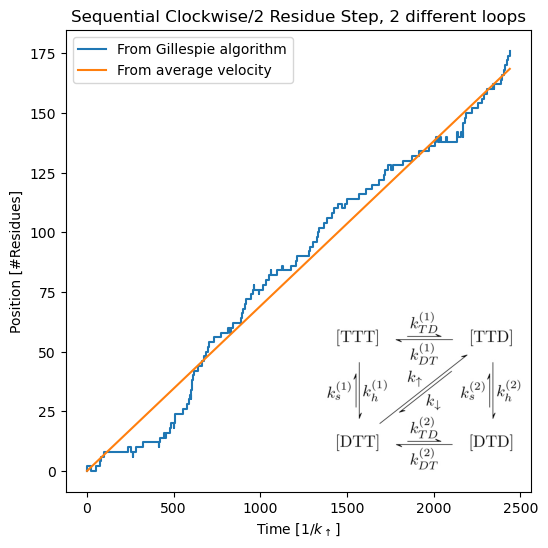

In [341]:
positions = SC_2R_2_different_loops.gillespie(positions=True)
fig, ax = SC_2R_2_different_loops.plot_position_evolution(
    positions, 
    r"$1/k_\uparrow$", 
    kinetic_scheme_image_path="SC_2R_2_different_loops_kinetic_scheme.jpg",
    title="Sequential Clockwise/2 Residue Step, 2 different loops")
plt.show()

### 2 similar loops

In [329]:
# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# Move up and down rates
k_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_down = k_h * k_up * k_DT / (k_s * k_TD) * ATP_over_ADP_equilibrium / ATP_over_ADP

# Analytical probability of being in each state
p_TTT = (k_s * k_DT * (k_h + k_s + k_up + k_down + k_DT + k_TD)
         + k_up * k_DT**2 + k_s**2 * k_down)
p_DTT = (k_h * k_DT * (k_h + k_s + k_down + k_DT + k_TD)
         + k_down * (k_h * k_s + k_s * k_TD + k_DT * k_TD))
p_DTD = (k_h * k_TD * (k_h + k_s + k_up + k_down + k_DT + k_TD)
         + k_h**2 * k_up + k_down * k_TD**2)
p_TTD = (k_s * k_TD * (k_h + k_s + k_up + k_DT + k_TD)
         + k_up * (k_h * k_s + k_h * k_DT + k_DT * k_TD))
normalization_factor = p_TTT + p_DTT + p_DTD + p_TTD
p_TTT /= normalization_factor
p_DTT /= normalization_factor
p_DTD /= normalization_factor
p_TTD /= normalization_factor

kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("TTT", {'probability': p_TTT}),
    ("DTT", {'probability': p_DTT}),
    ("DTD", {'probability': p_DTD}),
    ("TTD", {'probability': p_TTD})])
kinetic_scheme.add_edges_from([
    ("TTT", "DTT", {'rate': k_h}), # 1st loop hydrolisis/synthesis
    ("DTT", "TTT", {'rate': k_s}),
    ("DTT", "TTD", {'rate': k_up}), # up/down
    ("TTD", "DTT", {'rate': k_down}),
    ("TTD", "TTT", {'rate': k_DT}), # 1st loop ATP/ADP exchange
    ("TTT", "TTD", {'rate': k_TD}),
    ("DTT", "DTD", {'rate': k_TD}), # 2nd loop ATP/ADP exchange
    ("DTD", "DTT", {'rate': k_DT}),
    ("DTD", "TTD", {'rate': k_s}), # 2nd loop hydrolisis/synthesis
    ("TTD", "DTD", {'rate': k_h})])

SC_2R_2_similar_loops = DynamicalProcess(kinetic_scheme, ("DTT", "TTD"), 2)

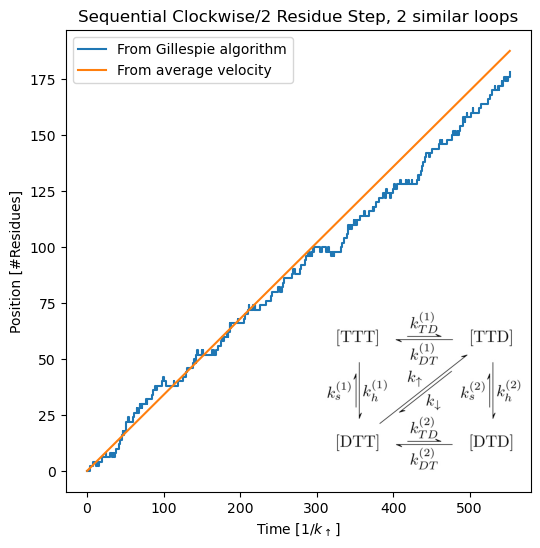

In [334]:
positions = SC_2R_2_similar_loops.gillespie(positions=True)
fig, ax = SC_2R_2_similar_loops.plot_position_evolution(
    positions, 
    r"$1/k_\uparrow$", 
    kinetic_scheme_image_path="SC_2R_2_different_loops_kinetic_scheme.jpg", # TODO create image
    title="Sequential Clockwise/2 Residue Step, 2 similar loops")
plt.show()

## Disc-Spiral model

![](Disc_spiral_kinetic_scheme.jpg)

In [332]:
n_protomers = 6

# ATP/ADP ratio concentrations
ATP_over_ADP = 10
ATP_over_ADP_equilibrium = 1

# Effective ATP/ADP exchange rates
k_DT = 1
# Constraint from ATP-ADP exchange model
k_TD = k_DT * K_d_ATP / K_d_ADP / ATP_over_ADP

# ATP/ADP hydrolysis/synthesis rates
k_bar_h = n_protomers * k_h

# Spiral-disc transitions in ATP mode
k_spiral_to_disc_up = 1
k_disc_to_spiral_down = 1

# Disc-spiral transitions in ADP mode
k_disc_to_spiral_up = 1 # Choosen to be the rate of reference for the unit of time
# Thermodynamic constraint from kinetic scheme
k_spiral_to_disc_down = (k_bar_h * k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up
                         / (k_s * k_TD * k_disc_to_spiral_down)
                         * ATP_over_ADP_equilibrium / ATP_over_ADP)

# Analytical probabilites in steady state
p_disc_ATP = (k_s * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_s * k_DT * k_spiral_to_disc_up
              + k_s * k_spiral_to_disc_down * k_TD
              + k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up)
p_disc_ADP = (k_bar_h * k_spiral_to_disc_down * k_TD
              + k_bar_h * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_spiral_to_disc_down * k_TD * k_disc_to_spiral_down
              + k_bar_h * k_DT * k_spiral_to_disc_up)
p_spiral_ADP = (k_disc_to_spiral_up * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_TD
                + k_s * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_spiral_to_disc_up)
p_spiral_ATP = (k_s * k_DT * k_disc_to_spiral_down
                + k_disc_to_spiral_up * k_DT * k_disc_to_spiral_down
                + k_s * k_spiral_to_disc_down * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_DT)
normalization_factor = p_disc_ATP + p_disc_ADP + p_spiral_ADP + p_spiral_ATP
p_disc_ATP /= normalization_factor
p_disc_ADP /= normalization_factor
p_spiral_ADP /= normalization_factor
p_spiral_ATP /= normalization_factor

kinetic_scheme = nx.DiGraph()
kinetic_scheme.add_nodes_from([
    ("━━", {'probability': p_disc_ATP}),
    ("┉┉", {'probability': p_disc_ADP}),
    ("┋", {'probability': p_spiral_ADP}),
    ("┃", {'probability': p_spiral_ATP})])
kinetic_scheme.add_edges_from([
    ("━━", "┉┉", {'rate': k_bar_h}), 
    ("┉┉", "━━", {'rate': k_s}),
    ("┉┉", "┋", {'rate': k_disc_to_spiral_up}), 
    ("┋", "┉┉", {'rate': k_spiral_to_disc_down}),
    ("┋", "┃", {'rate': k_DT}), 
    ("┃", "┋", {'rate': k_TD}),
    ("┃", "━━", {'rate': k_spiral_to_disc_up}), 
    ("━━", "┃", {'rate': k_disc_to_spiral_down})]
)

disc_spiral = DynamicalProcess(kinetic_scheme, ("┉┉", "┋"), 
                               n_residues_per_step=n_protomers-1, 
                               n_protomers=n_protomers)

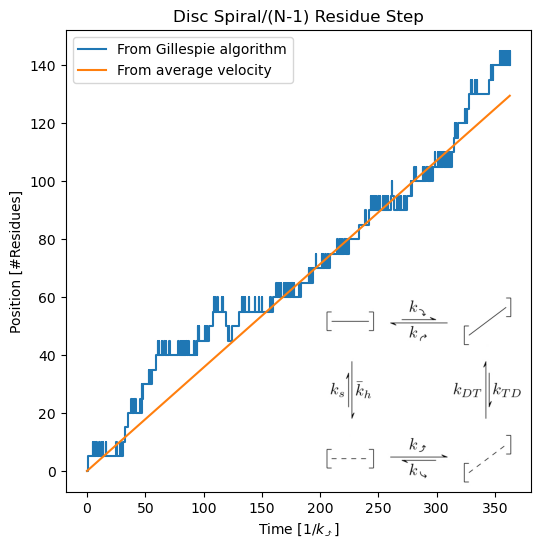

In [340]:
positions = disc_spiral.gillespie(positions=True)
fig, ax = disc_spiral.plot_position_evolution(
    positions, 
    r"$1/k_⤴$", 
    kinetic_scheme_image_path="Disc_spiral_kinetic_scheme.jpg",
    title="Disc Spiral/(N-1) Residue Step")
plt.show()

In [132]:
out = gillespie(model, "━━")
positions = compute_positions(out, transition_up=("┉┉", "┋"), transition_down=("┋", "┉┉"))

In [133]:
# Analytical average solutions

# Probability weights
p_disc_ATP = (k_s * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_s * k_DT * k_spiral_to_disc_up
              + k_s * k_spiral_to_disc_down * k_TD
              + k_disc_to_spiral_up * k_DT * k_spiral_to_disc_up)
p_disc_ADP = (k_bar_h * k_spiral_to_disc_down * k_TD
              + k_bar_h * k_spiral_to_disc_down * k_spiral_to_disc_up
              + k_spiral_to_disc_down * k_TD * k_disc_to_spiral_down
              + k_bar_h * k_DT * k_spiral_to_disc_up)
p_spiral_ADP = (k_disc_to_spiral_up * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_TD
                + k_s * k_TD * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_spiral_to_disc_up)
p_spiral_ATP = (k_s * k_DT * k_disc_to_spiral_down
                + k_disc_to_spiral_up * k_DT * k_disc_to_spiral_down
                + k_s * k_spiral_to_disc_down * k_disc_to_spiral_down
                + k_bar_h * k_disc_to_spiral_up * k_DT)
normalization_factor = p_disc_ATP + p_disc_ADP + p_spiral_ADP + p_spiral_ATP
p_disc_ATP /= normalization_factor
p_disc_ADP /= normalization_factor
p_spiral_ADP /= normalization_factor
p_spiral_ATP /= normalization_factor

# Average velocity
v = k_disc_to_spiral_up * p_disc_ADP - k_spiral_to_disc_down * p_spiral_ADP

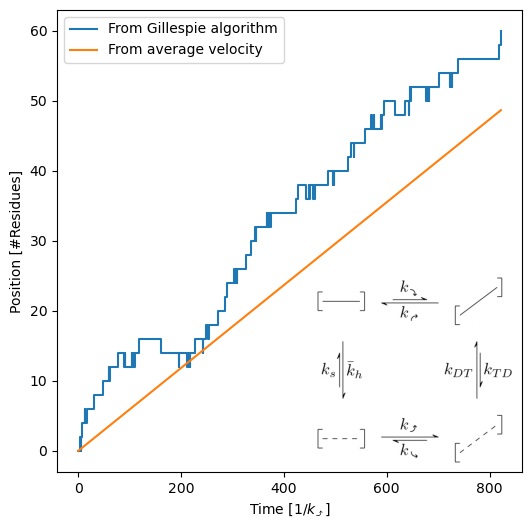

In [134]:
fig, ax = plot_position_evolution(positions, r"$1/k_⤴$", average_velocity=v, 
                        kinetic_scheme_path="Disc_spiral_kinetic_scheme.jpg")
fig.savefig("Disc_spiral_position_evolution.pdf", dpi=300, bbox_inches='tight')